# Text Mining Project 


In [5]:
# # # !pip install xgboost
# # !pip install imbalanced-learn
# !pip install tensorflow

In [71]:
import os
import re
import string
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# NLP: Text Processing and Tokenization
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Pipelines and Resampling
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Deep Learning (Keras/TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from keras.layers import Bidirectional


In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

## Load, Explore and Process the Data

In [8]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Dados'))

# Define file paths
train_file = os.path.join(data_path, 'train.csv')
test_file = os.path.join(data_path, 'test.csv')

# Load the datasets into DataFrames
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [9]:
print(df_train.head(5), df_train.tail(5))
print(df_test.head(5), df_test.tail(5))

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0                                                    text  label
9538  The Week's Gainers and Losers on the Stoxx Eur...      2
9539  Tupperware Brands among consumer gainers; Unil...      2
9540  vTv Therapeutics leads healthcare gainers; Myo...      2
9541    WORK, XPO, PYX and AMKR among after hour movers      2
9542             YNDX, I, QD and OESX among tech movers      2
   id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of 

In [10]:
# Count the number od words before processing 
df_train['num_words_before'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Stats
stats_train = df_train['num_words_before'].describe()


print("Number of words stats:")
print(stats_train)


Number of words stats:
count    9543.000000
mean       12.178351
std         4.665599
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        32.000000
Name: num_words_before, dtype: float64


In [11]:
# Count the number od words before processing 
df_test['num_words_before'] = df_test['text'].apply(lambda x: len(str(x).split()))

# Stats
stats_test = df_test['num_words_before'].describe()


print("Number of words stats:")
print(stats_test)


Number of words stats:
count    2388.000000
mean       12.321608
std         4.722062
min         1.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        33.000000
Name: num_words_before, dtype: float64


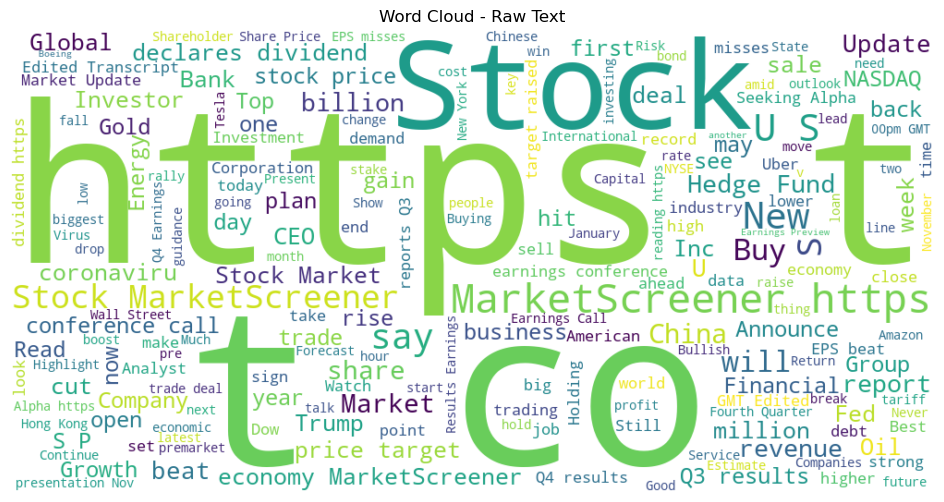

In [12]:
# Concat train 
raw_text_train = " ".join(str(t) for t in df_train['text'])

# word cloud
wordcloud_train = WordCloud(width=1000, height=500, background_color='white').generate(raw_text_train)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Raw Text")
plt.show()

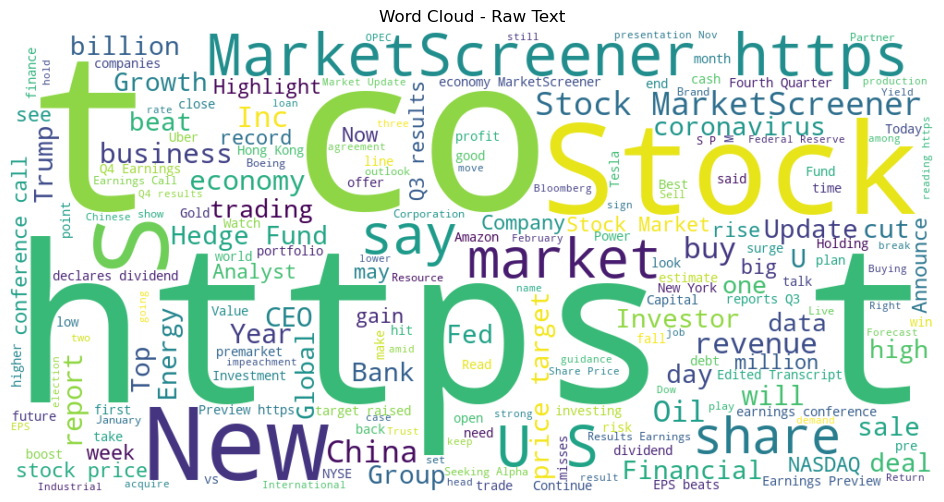

In [13]:
# Concat test
raw_text_test = " ".join(str(t) for t in df_test['text'])

# word cloud
wordcloud_test = WordCloud(width=1000, height=500, background_color='white').generate(raw_text_test)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Raw Text")
plt.show()

### Pre processing

In [14]:
stop_words = set(stopwords.words('english')) 

# Preprocessing
def clean_and_tokenize_nltk(text):
    # Lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)
    # Tokenização com nltk
    tokens = word_tokenize(text)
    # Remove ponctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply ao DataFrame
df_train['tokens'] = df_train['text'].apply(clean_and_tokenize_nltk)

In [15]:
# Count the number od words before processing 
df_train['num_words_after'] = df_train['tokens'].apply(lambda x: len(str(x).split()))

# Stats
stats_train = df_train['num_words_after'].describe()


print("Number of words stats:")
print(stats_train)


Number of words stats:
count    9543.000000
mean        7.648119
std         2.643857
min         1.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        27.000000
Name: num_words_after, dtype: float64


In [16]:
df_train

,text,label,num_words_before,tokens,num_words_after
0,$BYND - JPMorgan reels in expectations on Beyo...,0,10,"[bynd, jpmorgan, reels, expectations, beyond, ...",6
1,$CCL $RCL - Nomura points to bookings weakness...,0,14,"[ccl, rcl, nomura, points, bookings, weakness,...",9
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,14,"[cx, cemex, cut, credit, suisse, morgan, weak,...",9
3,$ESS: BTIG Research cuts to Neutral https://t....,0,7,"[ess, btig, research, cuts, neutral]",5
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,10,"[fnko, funko, slides, piper, jaffray, pt, cut]",7
...,...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,16,"[week, gainers, losers, stoxx, europe, economy...",7
9539,Tupperware Brands among consumer gainers; Unil...,2,9,"[tupperware, brands, among, consumer, gainers,...",8
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,11,"[vtv, therapeutics, leads, healthcare, gainers...",10
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9,"[work, xpo, pyx, amkr, among, hour, movers]",7


In [17]:
# Apply ao DataFrame
df_test['tokens'] = df_test['text'].apply(clean_and_tokenize_nltk)

In [18]:
# Count the number od words before processing 
df_test['num_words_after'] = df_test['tokens'].apply(lambda x: len(str(x).split()))

# Stats
stats_test = df_test['num_words_after'].describe()


print("Number of words stats:")
print(stats_test)


Number of words stats:
count    2388.000000
mean        7.742044
std         2.650189
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        21.000000
Name: num_words_after, dtype: float64


In [19]:
df_test

,id,text,num_words_before,tokens,num_words_after
0,0,ETF assets to surge tenfold in 10 years to $50...,15,"[etf, assets, surge, tenfold, years, trillion,...",9
1,1,Here’s What Hedge Funds Think Evolution Petrol...,9,"[hedge, funds, think, evolution, petroleum, co...",7
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...,9,"[pvh, heusen, earnings, preview]",4
3,3,China is in the process of waiving retaliatory...,22,"[china, process, waiving, retaliatory, tariffs...",10
4,4,"Highlight: “When growth is scarce, investors s...",17,"[highlight, growth, scarce, investors, seem, w...",9
...,...,...,...,...,...
2383,2383,$IVC - Invacare Corporation (IVC) CEO Matthew ...,17,"[ivc, invacare, corporation, ivc, ceo, matthew...",10
2384,2384,"Domtar EPS misses by $0.05, revenue in-line",7,"[domtar, eps, misses, revenue]",4
2385,2385,India Plans Incentives to Bring In Foreign Man...,12,"[india, plans, incentives, bring, foreign, man...",8
2386,2386,$NVCR shows institutional accumulation with bl...,19,"[nvcr, shows, institutional, accumulation, blu...",14


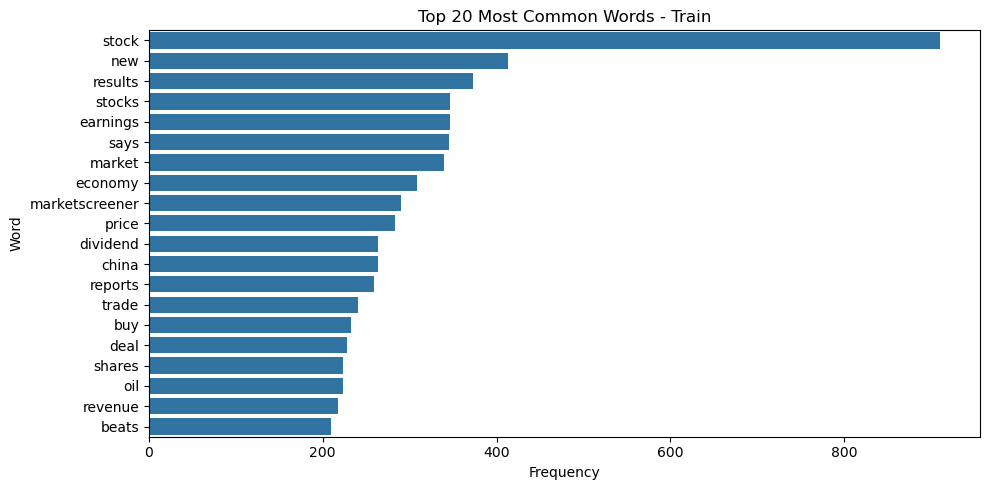

In [20]:
# Flatten the list of all tokens
all_tokens = [token for tokens in df_train['tokens'] for token in tokens]

# Calculate word frequencies
token_freq = Counter(all_tokens)
most_common = token_freq.most_common(20)

# Convert to DataFrame
freq_df = pd.DataFrame(most_common, columns=['word', 'frequency'])

# Plot the 20 most common words
plt.figure(figsize=(10, 5))
sns.barplot(x='frequency', y='word', data=freq_df)
plt.title('Top 20 Most Common Words - Train')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

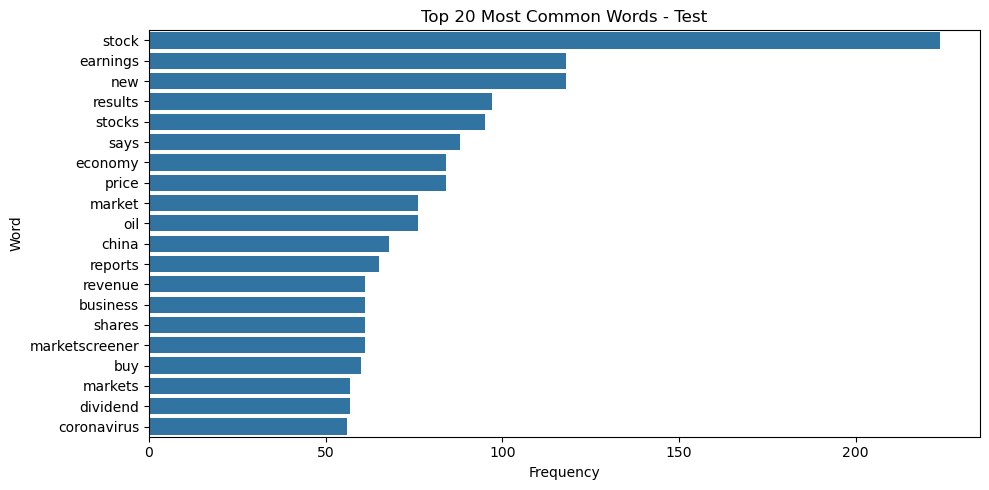

In [21]:
# Flatten the list of all tokens
all_tokens = [token for tokens in df_test['tokens'] for token in tokens]

# Calculate word frequencies
token_freq = Counter(all_tokens)
most_common = token_freq.most_common(20)

# Convert to DataFrame
freq_df = pd.DataFrame(most_common, columns=['word', 'frequency'])

# Plot the 20 most common words
plt.figure(figsize=(10, 5))
sns.barplot(x='frequency', y='word', data=freq_df)
plt.title('Top 20 Most Common Words - Test')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

C:\Users\rbern\AppData\Local\Temp\ipykernel_9892\1172918029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='label', palette='Set2')


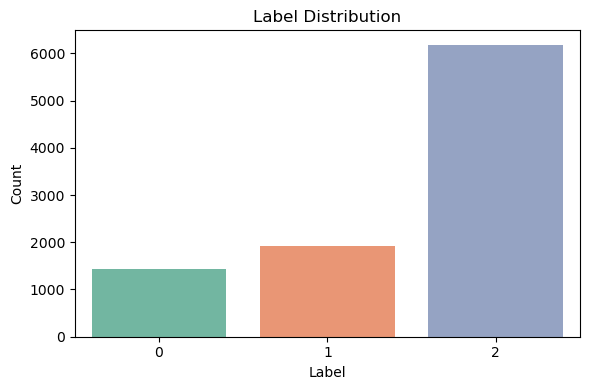

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x='label', palette='Set2')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

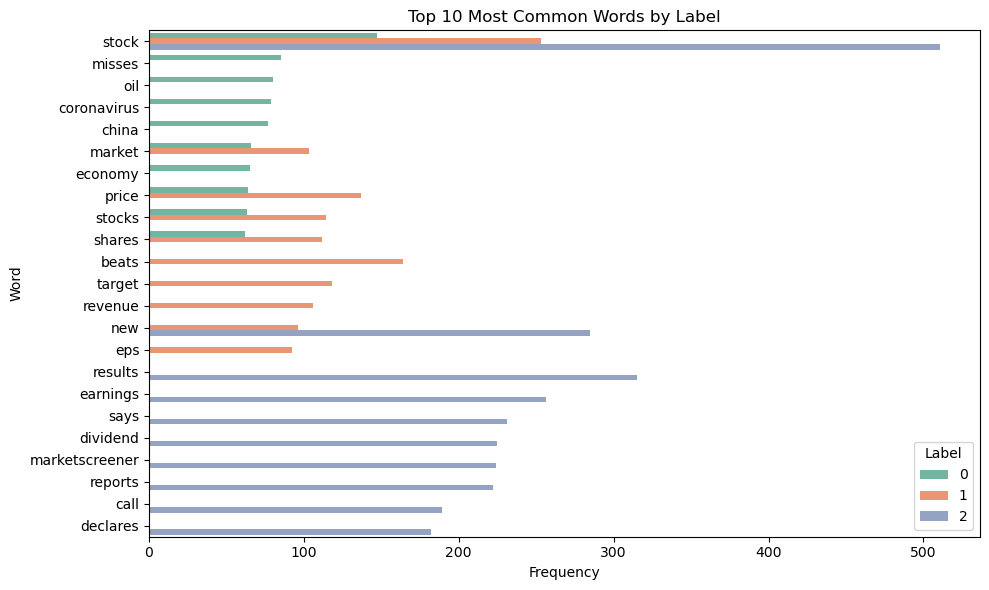

In [23]:
top_words_per_label = {}

# Frequency of tokens per label
for label in df_train['label'].unique():
    tokens = df_train[df_train['label'] == label]['tokens']
    flat_tokens = [token for sublist in tokens for token in sublist]
    freq = Counter(flat_tokens).most_common(10)
    top_words_per_label[label] = freq


top_words_df = pd.DataFrame([
    {'label': label, 'word': word, 'frequency': freq}
    for label, words in top_words_per_label.items()
    for word, freq in words
])


plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='frequency', y='word', hue='label', palette='Set2')
plt.title('Top 10 Most Common Words by Label')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

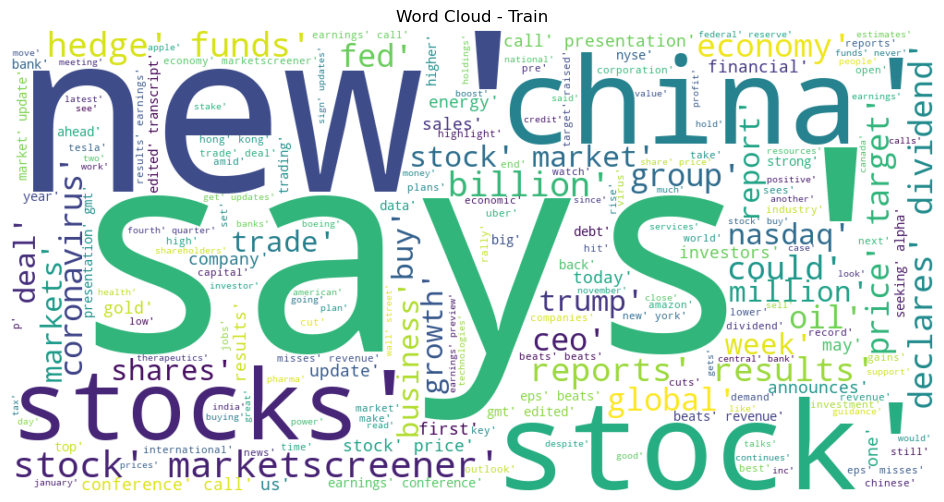

In [24]:
# Concat train 
text_train = " ".join(str(t) for t in df_train['tokens'])

# word cloud
wordcloud_train = WordCloud(width=1000, height=500, background_color='white').generate(text_train)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Train")
plt.show()

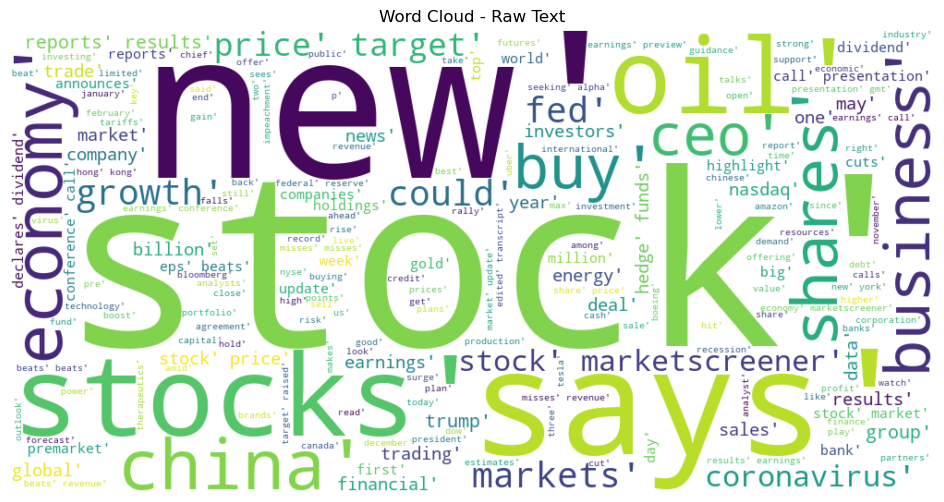

In [25]:
# Concat test
text_test = " ".join(str(t) for t in df_test['tokens'])

# word cloud
wordcloud_test = WordCloud(width=1000, height=500, background_color='white').generate(text_test)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Raw Text")
plt.show()

In [26]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_ngrams = vectorizer.fit_transform(df_train['text'])
ngrams_freq = zip(vectorizer.get_feature_names_out(), X_ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]


In [27]:
sorted_ngrams

[('marketscreener https', 478),
 ('stock marketscreener', 315),
 ('hedge funds', 163),
 ('price target', 141),
 ('economy marketscreener', 137),
 ('stock market', 137),
 ('stock price', 109),
 ('q3 results', 99),
 ('earnings conference', 90),
 ('conference presentation', 89),
 ('edited transcript', 89),
 ('stock https', 89),
 ('beats revenue', 85),
 ('seeking alpha', 85),
 ('market update', 84),
 ('eps beats', 82),
 ('alpha https', 80),
 ('reports q3', 79),
 ('target raised', 74),
 ('dividend https', 71)]

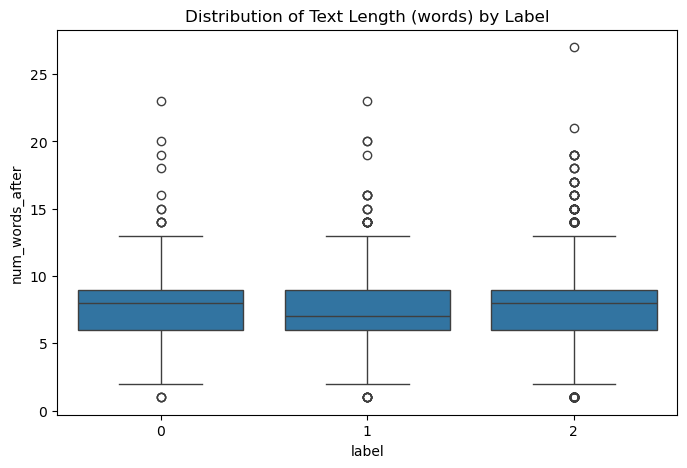

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='num_words_after', data=df_train)
plt.title("Distribution of Text Length (words) by Label")
plt.show()

In [41]:
df_train

,text,label,num_words_before,tokens,num_words_after,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,10,"[bynd, jpmorgan, reels, expectations, beyond, ...",6,bynd jpmorgan reels expectations beyond meat
1,$CCL $RCL - Nomura points to bookings weakness...,0,14,"[ccl, rcl, nomura, points, bookings, weakness,...",9,ccl rcl nomura points bookings weakness carniv...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,14,"[cx, cemex, cut, credit, suisse, morgan, weak,...",9,cx cemex cut credit suisse morgan weak buildin...
3,$ESS: BTIG Research cuts to Neutral https://t....,0,7,"[ess, btig, research, cuts, neutral]",5,ess btig research cuts neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,10,"[fnko, funko, slides, piper, jaffray, pt, cut]",7,fnko funko slides piper jaffray pt cut
...,...,...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,16,"[week, gainers, losers, stoxx, europe, economy...",7,week gainers losers stoxx europe economy marke...
9539,Tupperware Brands among consumer gainers; Unil...,2,9,"[tupperware, brands, among, consumer, gainers,...",8,tupperware brands among consumer gainers unile...
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,11,"[vtv, therapeutics, leads, healthcare, gainers...",10,vtv therapeutics leads healthcare gainers myom...
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9,"[work, xpo, pyx, amkr, among, hour, movers]",7,work xpo pyx amkr among hour movers


In [30]:
# Using the colum TEXT in raw
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_train['text'])
y = df_train['label']

In [ ]:
# # Using the tokens converted into a text 
# df_train['clean_text'] = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))


# tfidf = TfidfVectorizer(max_features=5000)
# X = tfidf.fit_transform(df_train['clean_text'])  # Clean Version
# y = df_train['label']


## Split the data and building models 

### Linear Regression

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [81]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [82]:
# Simple model 
model = LogisticRegression(max_iter=1000)
model.fit(X_res, y_res)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.19      0.15       288
           1       0.22      0.26      0.24       385
           2       0.65      0.52      0.57      1236

    accuracy                           0.42      1909
   macro avg       0.33      0.32      0.32      1909
weighted avg       0.48      0.42      0.44      1909



c:\Users\rbern\anaconda3\envs\TM2025\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Os resultados sem o preprocessing para a logistic ficaram melhores, acho que aqui o contexto importa mais que estar limpo 

* Texto original:


              precision    recall  f1-score   support

           0       0.78      0.40      0.53       288
           1       0.83      0.53      0.65       385
           2       0.78      0.96      0.86      1236

    accuracy                           0.79      1909
   macro avg       0.80      0.63      0.68      1909
weighted avg       0.79      0.79      0.77      1909


* Com preprocessing:

              precision    recall  f1-score   support

           0       0.77      0.34      0.47       288
           1       0.80      0.46      0.59       385
           2       0.76      0.96      0.85      1236

    accuracy                           0.77      1909
   macro avg       0.78      0.59      0.64      1909
weighted avg       0.77      0.77      0.74      1909

### Random Forest

In [83]:
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_res, y_res) # Com SMOTE

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.29      0.25      0.27       288
           1       0.45      0.35      0.39       385
           2       0.75      0.82      0.78      1236

    accuracy                           0.64      1909
   macro avg       0.49      0.47      0.48      1909
weighted avg       0.62      0.64      0.63      1909



### XGBoost

In [84]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_res, y_res) # Com SMOTE

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\rbern\anaconda3\envs\TM2025\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.27      0.30      0.28       288
           1       0.42      0.40      0.41       385
           2       0.78      0.76      0.77      1236

    accuracy                           0.62      1909
   macro avg       0.49      0.49      0.49      1909
weighted avg       0.63      0.62      0.62      1909



### Pipeline with Random Forest + SMOTE + Cross-Validation

In [85]:
# Pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

# Stratify Cross_Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metrics to validate
scores = cross_validate(
    pipeline,
    X, y,
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'],
    return_train_score=False
)

# Results
print("📊 Cross-validation results (Random Forest + SMOTE):\n")
for metric in scores:
    if 'test' in metric:
        print(f"{metric}: {scores[metric].mean():.4f}")


📊 Cross-validation results (Random Forest + SMOTE):

test_accuracy: 0.6529
test_precision_macro: 0.5106
test_recall_macro: 0.4881
test_f1_macro: 0.4960
test_f1_weighted: 0.6391


* Tentei com K = 50 e demorou mais e os resultados não foram muito melhor do que com K=5

## Non Classic Models

### F-IDF-weighted Word2Vec

In [86]:
# Junta os tokens por texto (exige string para o TfidfVectorizer)
texts_joined = df_train['tokens'].apply(lambda x: ' '.join(x))

# Calcula TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(texts_joined)
tfidf_vocab = tfidf.vocabulary_


In [87]:
# Mapeia os pesos TF-IDF para cada palavra
idf_weights = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

w2v_model = Word2Vec(sentences=df_train['tokens'], vector_size=100, window=5, min_count=1, workers=4, seed=42)

def tfidf_w2v(tokens):
    vecs = []
    for word in tokens:
        if word in w2v_model.wv and word in idf_weights:
            weight = idf_weights[word]
            vecs.append(w2v_model.wv[word] * weight)
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

# Aplica
X = np.vstack(df_train['tokens'].apply(tfidf_w2v))
y = df_train['label']


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       360
           1       0.51      0.15      0.23       481
           2       0.67      0.98      0.80      1545

    accuracy                           0.66      2386
   macro avg       0.73      0.38      0.34      2386
weighted avg       0.69      0.66      0.56      2386



### Modeling with Embeddings and LSTM (Keras)

In [89]:

# Parâmetros
max_vocab_size = 10000
max_len = 150
embedding_dim = 100

# Dados
texts = df_train['text'].astype(str).tolist()
labels = df_train['label'].tolist()

# Tokenização
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [90]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(32, return_sequences=False)))  
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # saída com 3 classes

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [91]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4157 - loss: 1.0980 - val_accuracy: 0.6574 - val_loss: 0.8116
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7983 - loss: 0.5886 - val_accuracy: 0.7758 - val_loss: 0.6372
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8746 - loss: 0.3313 - val_accuracy: 0.7528 - val_loss: 0.8091
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9284 - loss: 0.2233 - val_accuracy: 0.5521 - val_loss: 1.4875
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9508 - loss: 0.1541 - val_accuracy: 0.7307 - val_loss: 1.1564


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       288
           1       0.73      0.60      0.66       385
           2       0.86      0.86      0.86      1236

    accuracy                           0.78      1909
   macro avg       0.70      0.70      0.70      1909
weighted avg       0.78      0.78      0.78      1909



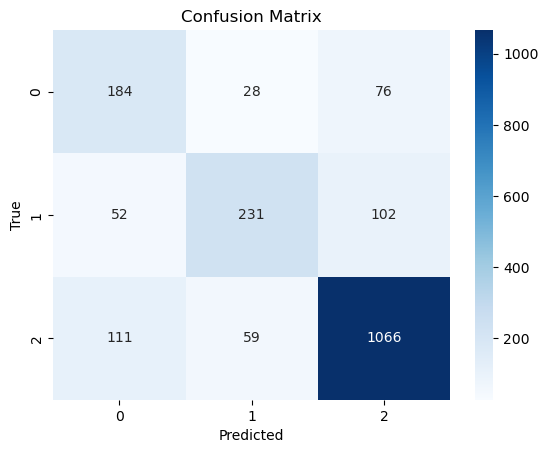

In [92]:
# Previsão
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Relatório de métricas
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


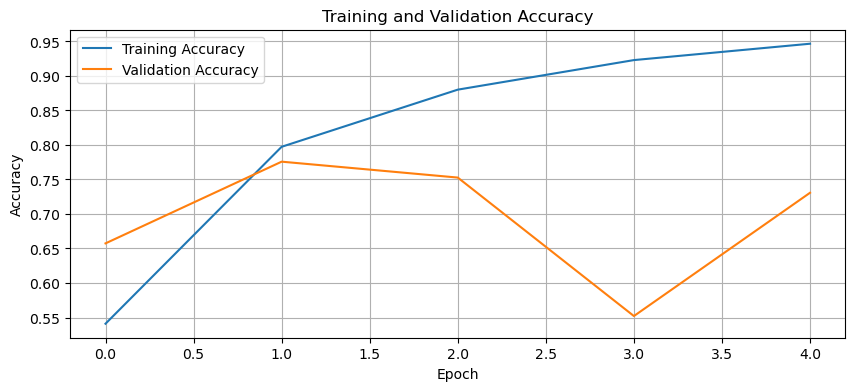

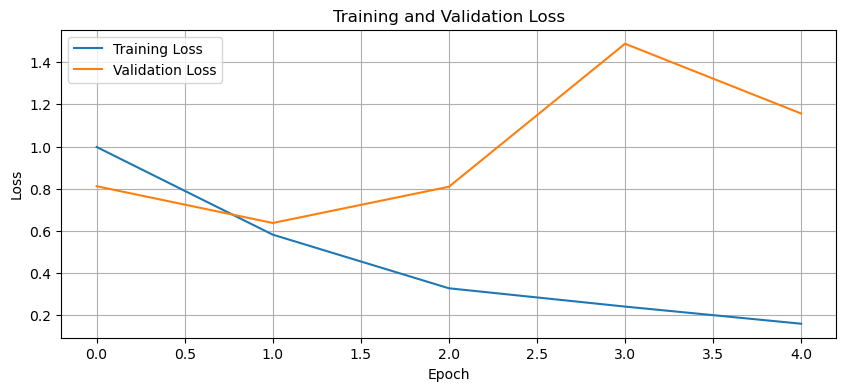

In [93]:

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Pipline to Model Selection and Hyperparameter Tuning

In [94]:
def build_model(config, max_vocab_size, embedding_dim, num_classes=3):
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim))

    if config['bidirectional']:
        model.add(Bidirectional(LSTM(config['lstm_units'], return_sequences=False)))
    else:
        model.add(LSTM(config['lstm_units'], return_sequences=False))

    if config['batch_norm']:
        model.add(BatchNormalization())

    if config['dropout1'] > 0:
        model.add(Dropout(config['dropout1']))

    model.add(Dense(config['dense_units'], activation='relu',
                    kernel_regularizer=l2(config['l2']) if config['l2'] > 0 else None))

    if config['dropout2'] > 0:
        model.add(Dropout(config['dropout2']))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [95]:
configs = [
    {'lstm_units': 32, 'bidirectional': True, 'batch_norm': True, 'dense_units': 64, 'dropout1': 0.4, 'dropout2': 0.3, 'l2': 0.001},
    {'lstm_units': 64, 'bidirectional': False, 'batch_norm': False, 'dense_units': 64, 'dropout1': 0.3, 'dropout2': 0.2, 'l2': 0.0005},
    {'lstm_units': 64, 'bidirectional': True, 'batch_norm': True, 'dense_units': 128, 'dropout1': 0.5, 'dropout2': 0.3, 'l2': 0.001},
    {'lstm_units': 32, 'bidirectional': False, 'batch_norm': False, 'dense_units': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'l2': 0.0}
]


In [96]:

results = []

for i, config in enumerate(configs):
    print(f"\n🔧 Training Model {i+1} with config: {config}")
    model = build_model(config, max_vocab_size=max_vocab_size, embedding_dim=embedding_dim)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=0
    )

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_test, y_pred_labels, average='macro')
    acc = history.history['val_accuracy'][-1]

    results.append({
        'config': config,
        'val_accuracy': acc,
        'f1_macro': f1,
        'model': model
    })

# Melhor resultado
best = max(results, key=lambda x: x['f1_macro'])

print("\n✅ Best configuration:")
print(f"Accuracy: {best['val_accuracy']:.4f}")
print(f"F1 Macro: {best['f1_macro']:.4f}")
print("Config:", best['config'])


🔧 Training Model 1 with config: {'lstm_units': 32, 'bidirectional': True, 'batch_norm': True, 'dense_units': 64, 'dropout1': 0.4, 'dropout2': 0.3, 'l2': 0.001}
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 Training Model 2 with config: {'lstm_units': 64, 'bidirectional': False, 'batch_norm': False, 'dense_units': 64, 'dropout1': 0.3, 'dropout2': 0.2, 'l2': 0.0005}
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

🔧 Training Model 3 with config: {'lstm_units': 64, 'bidirectional': True, 'batch_norm': True, 'dense_units': 128, 'dropout1': 0.5, 'dropout2': 0.3, 'l2': 0.001}
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

🔧 Training Model 4 with config: {'lstm_units': 32, 'bidirectional': False, 'batch_norm': False, 'dense_units': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'l2': 0.0}
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

✅ Best configuration:
Accuracy: 0.7658
F1 Macro: 0.7124
Config: {'lstm_units': 32, 'bidirectional': False, 'batch_norm': False, 'dense_units': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'l2': 0.0}

In [97]:

# Modelo com melhor configuração
best_model = Sequential()
best_model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim))
best_model.add(Bidirectional(LSTM(64, return_sequences=False)))
best_model.add(BatchNormalization())
best_model.add(Dropout(0.5))
best_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
best_model.add(Dropout(0.3))
best_model.add(Dense(3, activation='softmax'))  # 3 classes

best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treino
history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.4505 - loss: 1.1163 - val_accuracy: 0.7009 - val_loss: 0.8800
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.8272 - loss: 0.5257 - val_accuracy: 0.5490 - val_loss: 0.9314
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8844 - loss: 0.3077 - val_accuracy: 0.7737 - val_loss: 0.7877
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9255 - loss: 0.2320 - val_accuracy: 0.7559 - val_loss: 0.8394
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9498 - loss: 0.1735 - val_accuracy: 0.7695 - val_loss: 1.0677
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9615 - loss: 0.1318 - val_accuracy: 0.7297 - val_loss: 1.0830


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       288
           1       0.70      0.61      0.65       385
           2       0.84      0.87      0.86      1236

    accuracy                           0.77      1909
   macro avg       0.70      0.68      0.69      1909
weighted avg       0.77      0.77      0.77      1909



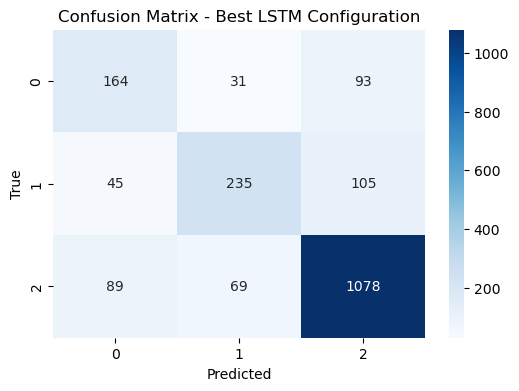

In [98]:
# Previsões
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best LSTM Configuration')
plt.show()
